<a href="https://colab.research.google.com/github/Isi2000/NLP/blob/main/CNN_for_genome_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for influenza

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
!pip install Bio
from Bio import SeqIO
import seaborn as sns
import torch.optim as optim

is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print("GPU is available" if is_cuda else "GPU not available, CPU used")

# Data
!git clone https://github.com/Isi2000/NLP.git
records = list(SeqIO.parse("NLP/ird_influenzaA_HA_allspecies.fa", "fasta"))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.2 MB/s eta 0:00:00
GPU is available
Cloning into 'NLP'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 10), reused 20 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 5.74 MiB | 5.96 MiB/s, done.
Resolving deltas: 100% (10/10), done.


## Functions


In [2]:
def extract_information(description, word):
    match = re.search(rf'{word}:([^()|]+)', description)
    if match:
        return match.group(1).strip()
    return None



In [3]:

sequences = []
total_seq = ""

for record in tqdm(records):
    seq = str(record.seq)
    label = extract_information(record.description, "Host")
    sequences.append((label, seq,))
    total_seq += seq

vocab_list = list(set(total_seq))
vocab_dict = {letter: idx for idx, letter in enumerate(vocab_list)}

datasets = defaultdict(list)
for label, seq in sequences:
    datasets[label].append((seq))

data = pd.DataFrame(sequences, columns=["Host", "Sequence" ])


min_occ = 2000
max_occ = 20000

host_counts = data['Host'].value_counts()
hosts_more_than_2000_entries = host_counts[(host_counts > min_occ) & (host_counts < max_occ)].index.tolist()
filtered_data = data[data['Host'].isin(hosts_more_than_2000_entries)].reset_index(drop=True)
filtered_data = filtered_data[filtered_data.Host != "Unknown"]
filtered_hosts = filtered_data['Host'].unique()
print(filtered_hosts)

filtered_data

data = filtered_data

labs = {host: idx for idx, host in enumerate(filtered_hosts)}
# Create Label column
data['Label'] = data['Host'].apply(lambda x: labs[x])
data = data.reset_index(drop=True)

data




100%|██████████| 94560/94560 [00:01<00:00, 91908.92it/s]


['Swine' 'Duck' 'Mallard' 'Chicken']


,Host,Sequence,Label
0,Swine,MKAIILVVLLYTFTTANADTLCIGYHANNSTDTVDTVLEKNVTVTH...,0
1,Duck,MIAIIVIAILAAAGRSDKICIGYHANNSTTQVDTILEKNVTVTHSV...,1
2,Mallard,MEAKLFVLFCTFTVLKADTICVGYHANNSTDTVDTVLEKNVTVTHS...,2
3,Duck,MKKTLLFAAIFLYVKADEICIGYLSNNSTDKVDTIIENNVTVTSSV...,1
4,Mallard,MKTIIALSYIFCLAFGQDLPGSDNSTATLCLGHHAVPNGTIVKTIT...,2
...,...,...,...
31545,Duck,MKKILLLAAIIICIQADEICIGYLSNNSTEKVDTIIESNVTVTSSV...,1
31546,Duck,MLSITILFLLIAEGSSQNYTGNPVICLGHHAVSNGTMVKTLTDDQV...,1
31547,Duck,MKTIIVLSCFFCLAFSQDLSENNNNTATLCLGHHAVPNGTIVKTIT...,1
31548,Duck,MLSIVILFLLIAEGSSQNYTGNPVICMGHHAVANGTMVKTLTDDQV...,1


In [4]:
def encode_sequence(sequence, vocab=vocab_dict):
    return np.array([vocab[aa] for aa in sequence])

data['Encoded_seq'] = data['Sequence'].apply(encode_sequence)

# Pad sequences
max_seq_length = max(data['Encoded_seq'].apply(len))

def pad_sequence(seq, max_length=max_seq_length):
    return np.pad(seq, (0, max_length - len(seq)), 'constant')

data['Padded_seq'] = data['Encoded_seq'].apply(pad_sequence)

# Prepare data for training
X = np.stack(data['Padded_seq'].values)
y = data['Label'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create Tensor datasets
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_test, y_test)

# Dataloaders
batch_size = 50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

# Print the shapes of the data
print(f'Shape of train data: {x_train.shape}')
print(f'Shape of test data: {x_test.shape}')

Shape of train data: torch.Size([23662, 576])
Shape of test data: torch.Size([7888, 576])


In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        return self.fc(cat)



In [10]:
# Parameters
INPUT_DIM = len(vocab_list)
EMBEDDING_DIM = 100
N_FILTERS = 500
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 4
DROPOUT = 0.2

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)
print(device)


cuda


In [30]:
def accuracy(preds, y):
    # Get the index of the max probability
    max_preds = preds.argmax(dim=1, keepdim=True)
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for inputs, labels in iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).squeeze(1)
            loss = criterion(predictions, labels)
            acc = accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

N_EPOCHS = 10

# Initialize lists to store the results
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    # Append the results to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')



 10%|█         | 1/10 [00:16<02:29, 16.61s/it]

| Epoch: 01 | Train Loss: 0.359 | Train Acc: 85.96% | Val. Loss: 0.311 | Val. Acc: 87.87% |


 20%|██        | 2/10 [00:32<02:11, 16.47s/it]

| Epoch: 02 | Train Loss: 0.357 | Train Acc: 86.32% | Val. Loss: 0.299 | Val. Acc: 88.26% |


 30%|███       | 3/10 [00:50<01:57, 16.73s/it]

| Epoch: 03 | Train Loss: 0.358 | Train Acc: 85.99% | Val. Loss: 0.337 | Val. Acc: 84.99% |


 40%|████      | 4/10 [01:06<01:40, 16.67s/it]

| Epoch: 04 | Train Loss: 0.367 | Train Acc: 85.46% | Val. Loss: 0.305 | Val. Acc: 88.15% |


 50%|█████     | 5/10 [01:23<01:23, 16.67s/it]

| Epoch: 05 | Train Loss: 0.359 | Train Acc: 85.40% | Val. Loss: 0.304 | Val. Acc: 87.78% |


 60%|██████    | 6/10 [01:40<01:06, 16.71s/it]

| Epoch: 06 | Train Loss: 0.358 | Train Acc: 85.67% | Val. Loss: 0.302 | Val. Acc: 87.71% |


 70%|███████   | 7/10 [01:56<00:50, 16.77s/it]

| Epoch: 07 | Train Loss: 0.365 | Train Acc: 85.52% | Val. Loss: 0.293 | Val. Acc: 88.57% |


 80%|████████  | 8/10 [02:13<00:33, 16.82s/it]

| Epoch: 08 | Train Loss: 0.358 | Train Acc: 86.01% | Val. Loss: 0.306 | Val. Acc: 88.65% |


 90%|█████████ | 9/10 [02:30<00:16, 16.87s/it]

| Epoch: 09 | Train Loss: 0.356 | Train Acc: 85.84% | Val. Loss: 0.299 | Val. Acc: 88.75% |


100%|██████████| 10/10 [02:47<00:00, 16.79s/it]

| Epoch: 10 | Train Loss: 0.347 | Train Acc: 86.39% | Val. Loss: 0.305 | Val. Acc: 87.80% |


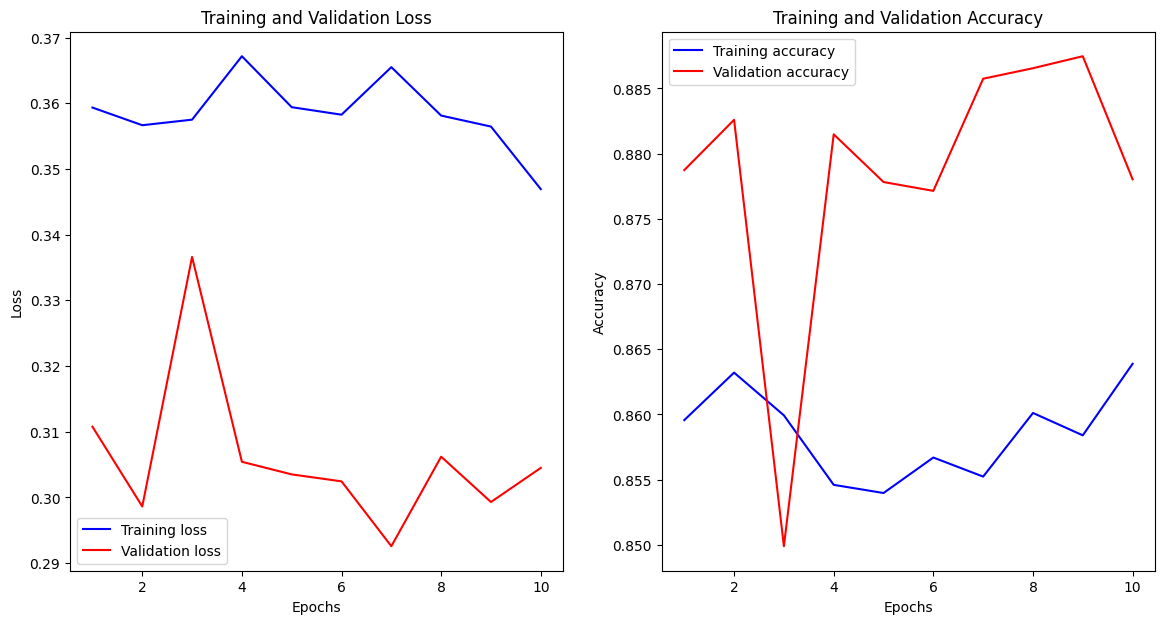

In [31]:
epochs = range(1, N_EPOCHS + 1)

plt.figure(figsize=(14, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


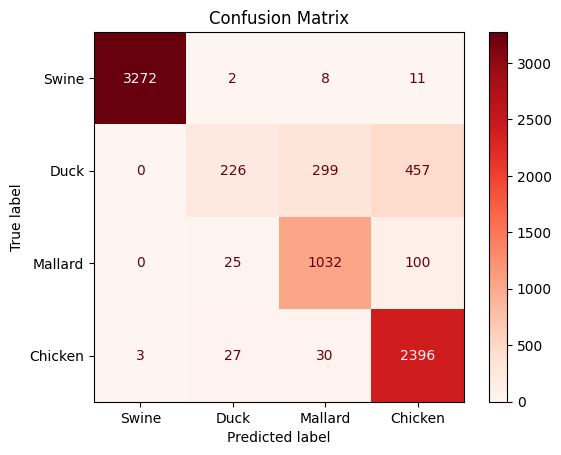

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_by_subtype(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            _, preds = torch.max(predictions, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[h for h in filtered_hosts])
    disp.plot(cmap=plt.cm.Reds)
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix for validation data by subtype
plot_confusion_matrix_by_subtype(model, valid_loader)


#Model on generated data

In [33]:
gen_data = pd.read_csv('NLP/generated_sequences.csv')

gen_data['Label'] = gen_data['Host'].apply(lambda x: labs[x])

gen_data['Encoded_seq'] = gen_data['Sequence'].apply(encode_sequence)
gen_data['Padded_seq'] = gen_data['Encoded_seq'].apply(pad_sequence)

X_gen = np.stack(gen_data['Padded_seq'].values)
y_gen = gen_data['Label'].values

x_gen = torch.tensor(X_gen, dtype=torch.long)
y_gen = torch.tensor(y_gen, dtype=torch.long)

gen_data_tensor = TensorDataset(x_gen, y_gen)

batch_size = 50
gen_loader = DataLoader(gen_data_tensor, shuffle=False, batch_size=batch_size)

print(f'Shape of generated test data: {x_gen.shape}')



Shape of generated test data: torch.Size([4000, 576])


In [34]:
model.eval()
gen_loss, gen_acc = evaluate(model, gen_loader, criterion)
print(f'Generated Data Performance: | Test Loss: {gen_loss:.3f} | Test Acc: {gen_acc*100:.2f}% |')


Generated Data Performance: | Test Loss: 2.264 | Test Acc: 32.15% |


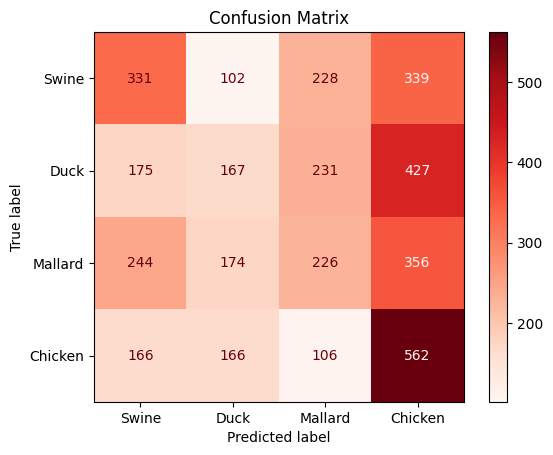

In [35]:
plot_confusion_matrix_by_subtype(model, gen_loader)
